In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler 
from tensorflow.keras.layers import Bidirectional, Attention
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import RobustScaler

In [ ]:
# Load and preprocess the data
def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path)
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    df.sort_values(['Ticker', 'Datetime'], inplace=True)

    feature_cols = ['Close', 'MACD_Buy', 'MACD_Sell', 'RSI_Buy', 'RSI_Sell', 'Stochs_Buy', 'Stochs_Sell',
                    'ADX_Buy', 'ADX_Sell', 'Aroon_Buy', 'Aroon_Sell', 'BOLL_Buy', 'BOLL_Sell', 'OSC_Buy', 'OSC_Sell']
    
    df = df[feature_cols + ['Datetime', 'Ticker']].dropna()
    df['Return'] = df.groupby('Ticker')['Close'].pct_change().shift(-1)  # Next period return as target
    df.dropna(inplace=True)

    return df, feature_cols

# Prepare sequences for LSTM training
def prepare_sequences(df, feature_cols, sequence_length=20):
    feature_scaler = RobustScaler()
    return_scaler = RobustScaler()
    
    X_scaled = feature_scaler.fit_transform(df[feature_cols])
    y_scaled = return_scaler.fit_transform(df[['Return']])

    X_sequences, y_sequences, dates, close_prices = [], [], df['Datetime'].values[sequence_length:], df['Close'].values[sequence_length:]

    for i in range(len(X_scaled) - sequence_length):
        X_sequences.append(X_scaled[i:i+sequence_length])
        y_sequences.append(y_scaled[i+sequence_length])

    return np.array(X_sequences), np.array(y_sequences), dates, close_prices, return_scaler

# Split data into training and testing sets
def split_data(X, y, dates, close_prices, train_ratio=0.8):
    split_index = int(len(X) * train_ratio)
    return X[:split_index], X[split_index:], y[:split_index], y[split_index:], dates[split_index:], close_prices[split_index:]

# Build improved LSTM model
def improved_lstm_model(input_shape):
    model = Sequential([
        Bidirectional(LSTM(128, return_sequences=True), input_shape=input_shape),
        Dropout(0.3),
        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.3),
        LSTM(32, return_sequences=False),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='mse',
                  metrics=['mae'])
    return model

# Function to train and evaluate the model
def train_and_evaluate_model(df, feature_cols, ticker):
    df_ticker = df[df['Ticker'] == ticker]
    X, y, dates, close_prices, return_scaler = prepare_sequences(df_ticker, feature_cols)

    # Train-test split (first 80% train, last 20% test)
    X_train, X_test, y_train, y_test, dates_test, close_prices_test = split_data(X, y, dates, close_prices)

    model = improved_lstm_model((X_train.shape[1], X_train.shape[2]))

    # Learning rate adjustment and early stopping
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)
    ]

    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=callbacks)

    # Predict and rescale returns
    y_pred_scaled = model.predict(X_test)
    y_pred = return_scaler.inverse_transform(y_pred_scaled)
    y_test = return_scaler.inverse_transform(y_test.reshape(-1, 1))

    return model, y_test, y_pred, dates_test, close_prices_test

# Function to log trades and calculate cumulative return
def log_trades(dates, actual_returns, predicted_returns, close_prices, ticker):
    positions = ['LONG' if pred > 0 else 'SHORT' for pred in predicted_returns.flatten()]
    cumulative_return = np.cumprod(1 + (actual_returns * (np.array(positions) == 'LONG') - actual_returns * (np.array(positions) == 'SHORT'))) - 1
    
    trades = pd.DataFrame({
        'Date': dates,
        'Stock_Close_Price': close_prices,
        'Predicted_Return': predicted_returns.flatten(),
        'Actual_Return': actual_returns,
        'Position': positions,
        'Cumulative_Return': cumulative_return,
        'Ticker': ticker
    })
    
    return trades

# Function to plot cumulative returns for each stock
def plot_cumulative_returns(all_trades_df):
    plt.figure(figsize=(12, 6))
    for ticker in all_trades_df['Ticker'].unique():
        df_ticker = all_trades_df[all_trades_df['Ticker'] == ticker]
        plt.plot(df_ticker['Date'], df_ticker['Cumulative_Return'], label=ticker)
    
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.title('Cumulative Returns for Each Stock')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

# Function to plot stock price
def plot_stock_price(df, ticker):
    df_ticker = df[df['Ticker'] == ticker]
    plt.figure(figsize=(12, 6))
    plt.plot(df_ticker['Datetime'], df_ticker['Close'], label=f'{ticker} Stock Price', color='green')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.title(f'{ticker} Stock Price Over Time')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

# Function to plot actual vs predicted returns
def plot_returns(dates, actual_returns, predicted_returns, ticker):
    plt.figure(figsize=(12, 6))
    plt.plot(dates, actual_returns, label='Actual Returns', color='blue')
    plt.plot(dates, predicted_returns.flatten(), label='Predicted Returns', color='red')
    plt.xlabel('Date')
    plt.ylabel('Stock Return')
    plt.title(f'Actual vs Predicted Stock Returns for {ticker}')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

# Load dataset
file_path = "stock_prices_with_signals.csv"
df, feature_cols = load_and_preprocess_data(file_path)

# Loop through each ticker and process data
all_trades = []
unique_tickers = df['Ticker'].unique()

for ticker in unique_tickers:
    print(f"Processing {ticker}...")
    model, y_test, y_pred, dates_test, close_prices_test = train_and_evaluate_model(df, feature_cols, ticker)

    # Log trades and update cumulative returns
    trades = log_trades(dates_test, y_test.flatten(), y_pred.flatten(), close_prices_test, ticker)
    all_trades.append(trades)

# Combine all trades into a single DataFrame
all_trades_df = pd.concat(all_trades, ignore_index=True)

# Plot cumulative returns for all stocks
plot_cumulative_returns(all_trades_df)


Processing AAPL...


c:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 26s 131ms/step - loss: 2.1022 - mae: 0.7174 - val_loss: 2.4790 - val_mae: 1.0971 - learning_rate: 0.0010
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 131ms/step - loss: 1.6957 - mae: 0.6805 - val_loss: 2.5170 - val_mae: 1.1044 - learning_rate: 0.0010
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - loss: 1.1859 - mae: 0.6527 - val_loss: 2.4762 - val_mae: 1.0964 - learning_rate: 0.0010
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - loss: 1.2616 - mae: 0.6697 - val_loss: 2.4715 - val_mae: 1.0970 - learning_rate: 0.0010
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 1.5001 - mae: 0.6871 - val_loss: 2.4744 - val_mae: 1.0969 - learning_rate: 0.0010
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 1.4803 - mae: 0.6758 - val_loss: 2.4531 - val_mae: 1.0940 - learning_rate: 0.0010
Epoch 7/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 1.4564 - mae: 0.7057 - val_loss: 2.4652 - val_mae: 1.0953 - learning_rate: 0.0010
Epoch 8/5

c:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 16s 56ms/step - loss: 1.1674 - mae: 0.6593 - val_loss: 2.8347 - val_mae: 1.1658 - learning_rate: 0.0010
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 1.3720 - mae: 0.6636 - val_loss: 2.8405 - val_mae: 1.1630 - learning_rate: 0.0010
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 1.1471 - mae: 0.6495 - val_loss: 2.8391 - val_mae: 1.1706 - learning_rate: 0.0010
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 1.2340 - mae: 0.6651 - val_loss: 2.8442 - val_mae: 1.1644 - learning_rate: 0.0010
Epoch 5/50
48/80 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 1.1186 - mae: 0.6373

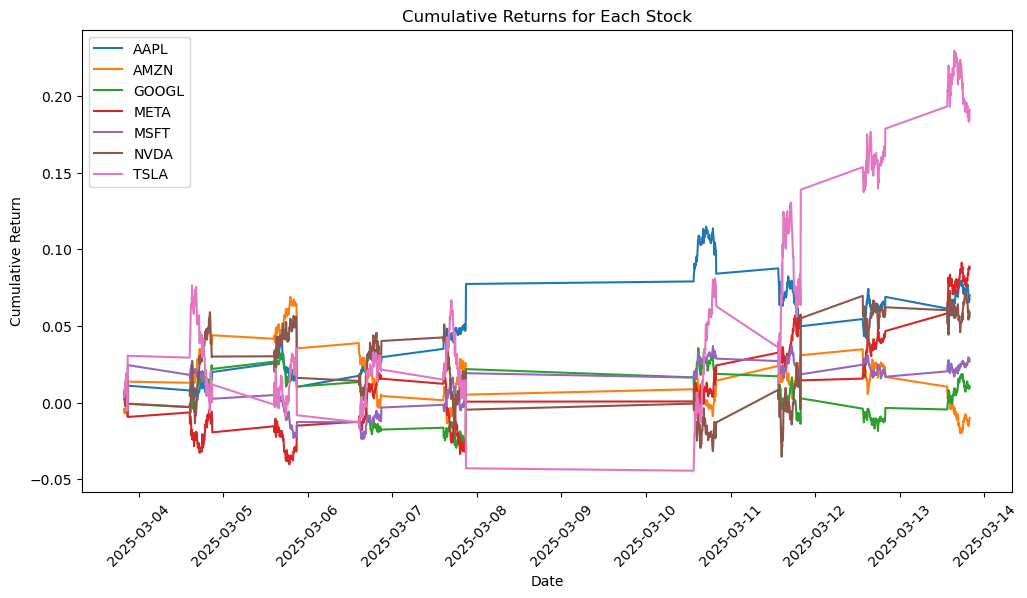

In [ ]:
plot_cumulative_returns(all_trades_df)

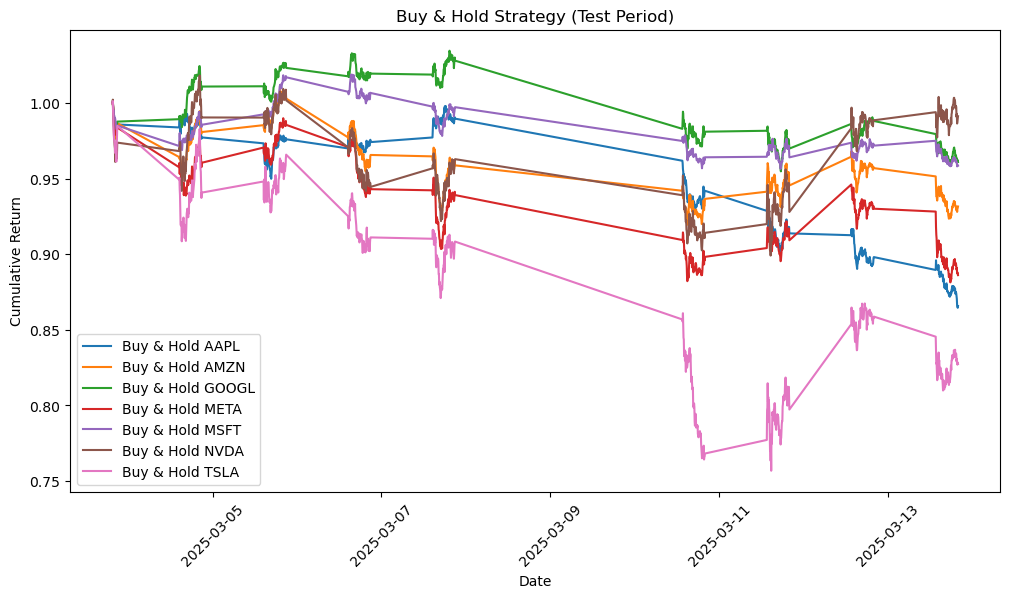

In [ ]:
# Reload the dataset
file_path = "stock_prices_with_signals.csv"
df, feature_cols = load_and_preprocess_data(file_path)

# Function to plot Buy & Hold strategy for the test period (last 20% of the dataset)
def plot_buy_and_hold_test_period(df):
    plt.figure(figsize=(12, 6))

    for ticker in df['Ticker'].unique():
        df_ticker = df[df['Ticker'] == ticker].sort_values('Datetime')

        # Split data (80% train, 20% test)
        split_index = int(len(df_ticker) * 0.8)
        df_test = df_ticker.iloc[split_index:]  # Select last 20%

        if df_test.empty:
            continue  # Skip if no test data

        initial_price = df_test['Close'].iloc[0]
        buy_and_hold_returns = df_test['Close'] / initial_price  # Normalize returns

        plt.plot(df_test['Datetime'], buy_and_hold_returns, label=f'Buy & Hold {ticker}')

    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.title('Buy & Hold Strategy (Test Period)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

# Plot the Buy & Hold strategy for the test period
plot_buy_and_hold_test_period(df)


In [ ]:
# Function to calculate returns for both strategies during the test period
def calculate_strategy_returns(df, all_trades_df):
    results = []

    for ticker in df['Ticker'].unique():
        df_ticker = df[df['Ticker'] == ticker].sort_values('Datetime')

        # Split data (80% train, 20% test)
        split_index = int(len(df_ticker) * 0.8)
        df_test = df_ticker.iloc[split_index:]  # Select last 20%

        if df_test.empty:
            continue  # Skip if no test data

        # Buy & Hold Strategy Return
        initial_price = df_test['Close'].iloc[0]
        final_price = df_test['Close'].iloc[-1]
        buy_and_hold_return = (final_price / initial_price) - 1

        # Trading Strategy Return (from the logged trades)
        df_trades = all_trades_df[all_trades_df['Ticker'] == ticker]
        strategy_return = df_trades['Cumulative_Return'].iloc[-1] if not df_trades.empty else None

        results.append({
            "Ticker": ticker,
            "Buy & Hold Return (%)": round(buy_and_hold_return * 100, 2),
            "Trading Strategy Return (%)": round(strategy_return * 100, 2) if strategy_return is not None else None
        })

    return pd.DataFrame(results)

# Check if trading results exist
if 'all_trades_df' in globals():
    strategy_returns_df = calculate_strategy_returns(df, all_trades_df)
    print(strategy_returns_df)
else:
    print("Trading strategy results are missing. Please re-run the trading model first.")


  Ticker  Buy & Hold Return (%)  Trading Strategy Return (%)
0   AAPL                 -13.42                         7.00
1   AMZN                  -6.84                        -1.00
2  GOOGL                  -3.90                         1.08
3   META                 -11.38                         8.75
4   MSFT                  -4.13                         2.68
5   NVDA                  -0.86                         5.61
6   TSLA                 -17.25                        19.11
